<a href="https://colab.research.google.com/github/TheKeiser/ai-ml-principles-exercises/blob/main/ML-training/logging-trainings-with-WandB/Inlamning1_Patrik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies and import packages



In [1]:
import sys
!{sys.executable} -m pip install numpy tensorflow
from IPython.display import clear_output
clear_output()
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, datasets, models

from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


!pip install wandb
import wandb

from wandb.keras import WandbCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 9.4 MB/s 
     |████████████████████████████████| 182 kB 58.8 MB/s 
     |████████████████████████████████| 168 kB 70.1 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 168 kB 83.8 MB/s 
     |████████████████████████████████| 166 kB 80.9 MB/s 
     |████████████████████████████████| 166 kB 84.9 MB/s 
     |████████████████████████████████| 162 kB 85.8 MB/s 
     |████████████████████████████████| 162 kB 72.8 MB/s 
     |████████████████████████████████| 158 kB 86.1 MB/s 
     |████████████████████████████████| 157 kB 84.8 MB/s 
     |████████████████████████████████| 157 kB 85.3 MB/s 
     |████████████████████████████████| 157 kB 81.2 MB/s 
     |████████████████████████████████| 157 kB 74.7 MB/s 
     |████████████████████████████████| 157 kB 84.2 MB/s 
     |████████████████████████████

In [2]:
import matplotlib.pyplot as plt

## Create a neural network
Using  a simple CNN (convolutional neural network) and a model more adapted for the conditions such as cifar10. Both will be used in the analysis.


Model 1 (same as exercise 3)

In [3]:
def create_cnn(input_shape, output_classes):
    return keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(output_classes, activation="softmax"),
        ]
    )

Model 2 

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [6]:
model.summary() #displays summary of model used

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 10)                2

## Prepare the data
Get data and preprocess - model 1 and 2.


For model 1 

In [ ]:
def get_cifar_data(): #cifar data installed
    # Load the data and split it between train and test sets
    (image_train, label_train), (image_test, label_test) = datasets.cifar10.load_data()

    # Scale images to the [0, 1] range
    image_train = image_train.astype("float32") / 255
    image_test = image_test.astype("float32") / 255

    # Make sure images have shape (32, 32, 3)
    image_train = np.expand_dims(image_train, -1)
    image_test = np.expand_dims(image_test, -1)

    # convert class vectors to binary class matrices
    num_classes = 10
    label_train = keras.utils.to_categorical(label_train, num_classes)
    label_test = keras.utils.to_categorical(label_test, num_classes)

    return (image_train, label_train), (image_test, label_test)

In [ ]:
(image_train, label_train), (image_test, label_test) = get_cifar_data()

For model 2 

In [ ]:
(image_train, label_train), (image_test, label_test) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
image_train, image_test = image_train / 255.0, image_test / 255.0

Check 15 images (for model 2, can be done for model 1 as well)

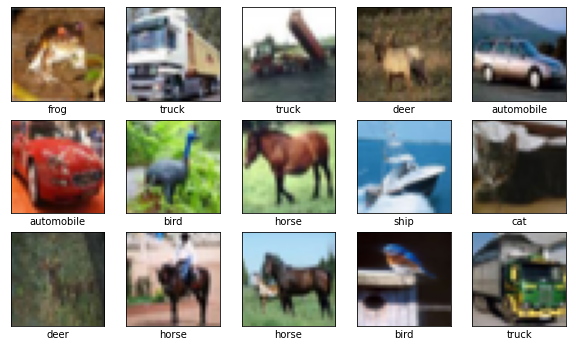

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[label_train[i][0]])
plt.show()

For using limited number of pictures in dataset (model 1)
Normally 1/5 or 1/10 is used for test but will use same amount in this case.

In [ ]:
image_train = image_train[:500]
label_train = label_train[:500]
image_test = image_test[:500]
label_test = label_test[:500]

##Runs
Prepare model and datacollection for testrun

In [ ]:
batch_size = 128
epochs = 15
wandb.init(project="inlamning1", config={"batch_size": batch_size, "epochs": epochs})

wandb: Currently logged in as: patrik_hoj (patrikh). Use `wandb login --relogin` to force relogin


Run/train model 1

In [ ]:
model = create_cnn((32, 32, 3), 10)
#validation_split=0.1

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])
model.fit(image_train, label_train, batch_size=batch_size,
          epochs=epochs, validation_data=(image_test, label_test),
          callbacks=[wandb.keras.WandbCallback()])
wandb.finish()

Epoch 1/60
1/4 [======>.......................] - ETA: 1s - loss: 2.3155 - accuracy: 0.0781

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 314ms/step - loss: 2.3002 - accuracy: 0.1500 - val_loss: 2.2942 - val_accuracy: 0.0860
Epoch 2/60
1/4 [======>.......................] - ETA: 0s - loss: 2.2784 - accuracy: 0.1016

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 354ms/step - loss: 2.2532 - accuracy: 0.1380 - val_loss: 2.2706 - val_accuracy: 0.0820
Epoch 3/60
1/4 [======>.......................] - ETA: 0s - loss: 2.2251 - accuracy: 0.1562

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 247ms/step - loss: 2.2169 - accuracy: 0.1300 - val_loss: 2.2445 - val_accuracy: 0.1060
Epoch 4/60
1/4 [======>.......................] - ETA: 0s - loss: 2.1838 - accuracy: 0.1641

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 241ms/step - loss: 2.1601 - accuracy: 0.1920 - val_loss: 2.1776 - val_accuracy: 0.1640
Epoch 5/60
1/4 [======>.......................] - ETA: 0s - loss: 2.1369 - accuracy: 0.2188

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 250ms/step - loss: 2.0852 - accuracy: 0.2720 - val_loss: 2.1056 - val_accuracy: 0.2240
Epoch 6/60
1/4 [======>.......................] - ETA: 0s - loss: 2.0541 - accuracy: 0.2891

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 430ms/step - loss: 2.0141 - accuracy: 0.3200 - val_loss: 2.0383 - val_accuracy: 0.2460
Epoch 7/60
1/4 [======>.......................] - ETA: 0s - loss: 1.9486 - accuracy: 0.3516

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 251ms/step - loss: 1.9291 - accuracy: 0.3620 - val_loss: 1.9939 - val_accuracy: 0.2880
Epoch 8/60
1/4 [======>.......................] - ETA: 0s - loss: 1.7566 - accuracy: 0.4844

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 1.8632 - accuracy: 0.3640 - val_loss: 1.9533 - val_accuracy: 0.3100
Epoch 9/60
1/4 [======>.......................] - ETA: 0s - loss: 1.7586 - accuracy: 0.3906

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.7704 - accuracy: 0.4220 - val_loss: 1.9238 - val_accuracy: 0.3060
Epoch 10/60
1/4 [======>.......................] - ETA: 0s - loss: 1.6698 - accuracy: 0.4453

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 256ms/step - loss: 1.7086 - accuracy: 0.4420 - val_loss: 1.9164 - val_accuracy: 0.3040
Epoch 11/60
1/4 [======>.......................] - ETA: 0s - loss: 1.5856 - accuracy: 0.4609

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 350ms/step - loss: 1.6398 - accuracy: 0.4360 - val_loss: 1.8858 - val_accuracy: 0.3180
Epoch 12/60
1/4 [======>.......................] - ETA: 0s - loss: 1.6096 - accuracy: 0.4844

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 1.6001 - accuracy: 0.4560 - val_loss: 1.8782 - val_accuracy: 0.3200
Epoch 13/60
1/4 [======>.......................] - ETA: 0s - loss: 1.5736 - accuracy: 0.4844

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.5499 - accuracy: 0.4780 - val_loss: 1.8726 - val_accuracy: 0.3160
Epoch 14/60
1/4 [======>.......................] - ETA: 0s - loss: 1.4650 - accuracy: 0.5156

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 255ms/step - loss: 1.4957 - accuracy: 0.4780 - val_loss: 1.8552 - val_accuracy: 0.3460
Epoch 15/60
4/4 [==============================] - 0s 19ms/step - loss: 1.4653 - accuracy: 0.5200 - val_loss: 1.8649 - val_accuracy: 0.3360
Epoch 16/60
4/4 [==============================] - 0s 20ms/step - loss: 1.4492 - accuracy: 0.5000 - val_loss: 1.8573 - val_accuracy: 0.3320
Epoch 17/60
1/4 [======>.......................] - ETA: 0s - loss: 1.3636 - accuracy: 0.5156

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.4169 - accuracy: 0.5300 - val_loss: 1.8401 - val_accuracy: 0.3320
Epoch 18/60
4/4 [==============================] - 0s 18ms/step - loss: 1.3733 - accuracy: 0.5420 - val_loss: 1.8486 - val_accuracy: 0.3460
Epoch 19/60
4/4 [==============================] - 0s 19ms/step - loss: 1.3308 - accuracy: 0.5720 - val_loss: 1.8484 - val_accuracy: 0.3360
Epoch 20/60
4/4 [==============================] - 0s 19ms/step - loss: 1.3030 - accuracy: 0.5760 - val_loss: 1.8445 - val_accuracy: 0.3580
Epoch 21/60
1/4 [======>.......................] - ETA: 0s - loss: 1.3732 - accuracy: 0.5391

wandb: Adding directory to artifact (/content/wandb/run-20221212_132148-2ycm6m1y/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 1.2656 - accuracy: 0.5820 - val_loss: 1.8210 - val_accuracy: 0.3560
Epoch 22/60
4/4 [==============================] - 0s 20ms/step - loss: 1.2352 - accuracy: 0.5940 - val_loss: 1.8289 - val_accuracy: 0.3540
Epoch 23/60
4/4 [==============================] - 0s 17ms/step - loss: 1.1976 - accuracy: 0.6140 - val_loss: 1.8268 - val_accuracy: 0.3600
Epoch 24/60
4/4 [==============================] - 0s 22ms/step - loss: 1.1808 - accuracy: 0.6280 - val_loss: 1.8441 - val_accuracy: 0.3500
Epoch 25/60
4/4 [==============================] - 0s 19ms/step - loss: 1.1464 - accuracy: 0.6280 - val_loss: 1.8685 - val_accuracy: 0.3440
Epoch 26/60
4/4 [==============================] - 0s 33ms/step - loss: 1.1525 - accuracy: 0.6260 - val_loss: 1.8325 - val_accuracy: 0.3620
Epoch 27/60
4/4 [==============================] - 0s 20ms/step - loss: 1.1132 - accuracy: 0.6400 - val_loss: 1.8620 - val_accuracy: 0.3540
Epoch 28/60
4/4 [==============

accuracy,▁▁▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▃▄▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇█▇█▇█████▇███▇█▇████
val_loss,██▆▅▄▃▂▂▂▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▆▅▆▆▆
accuracy,0.894
best_epoch,20
best_val_loss,1.82105
epoch,59
loss,0.45955
val_accuracy,0.382


Run/train model 2

In [ ]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(image_train, label_train, epochs=epochs, 
          validation_data=(image_test, label_test),
          callbacks=[wandb.keras.WandbCallback()])
wandb.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/15
1563/1563 [==============================] - ETA: 0s - loss: 1.5172 - accuracy: 0.4433

wandb: Adding directory to artifact (/content/wandb/run-20221212_144445-21g55ye8/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 11s 5ms/step - loss: 1.5172 - accuracy: 0.4433 - val_loss: 1.2286 - val_accuracy: 0.5588
Epoch 2/15
1550/1563 [============================>.] - ETA: 0s - loss: 1.1441 - accuracy: 0.5933

wandb: Adding directory to artifact (/content/wandb/run-20221212_144445-21g55ye8/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 8s 5ms/step - loss: 1.1432 - accuracy: 0.5938 - val_loss: 1.1319 - val_accuracy: 0.6076
Epoch 3/15
1559/1563 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.6525

wandb: Adding directory to artifact (/content/wandb/run-20221212_144445-21g55ye8/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 8s 5ms/step - loss: 0.9878 - accuracy: 0.6524 - val_loss: 1.0267 - val_accuracy: 0.6362
Epoch 4/15
1554/1563 [============================>.] - ETA: 0s - loss: 0.8997 - accuracy: 0.6821

wandb: Adding directory to artifact (/content/wandb/run-20221212_144445-21g55ye8/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 9s 6ms/step - loss: 0.8993 - accuracy: 0.6822 - val_loss: 0.9067 - val_accuracy: 0.6889
Epoch 5/15
1555/1563 [============================>.] - ETA: 0s - loss: 0.8315 - accuracy: 0.7090

wandb: Adding directory to artifact (/content/wandb/run-20221212_144445-21g55ye8/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 9s 6ms/step - loss: 0.8309 - accuracy: 0.7093 - val_loss: 0.8864 - val_accuracy: 0.6927
Epoch 6/15
1554/1563 [============================>.] - ETA: 0s - loss: 0.7750 - accuracy: 0.7268

wandb: Adding directory to artifact (/content/wandb/run-20221212_144445-21g55ye8/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 8s 5ms/step - loss: 0.7755 - accuracy: 0.7267 - val_loss: 0.8765 - val_accuracy: 0.6984
Epoch 7/15
1560/1563 [============================>.] - ETA: 0s - loss: 0.7250 - accuracy: 0.7470

wandb: Adding directory to artifact (/content/wandb/run-20221212_144445-21g55ye8/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 8s 5ms/step - loss: 0.7248 - accuracy: 0.7471 - val_loss: 0.8574 - val_accuracy: 0.7031
Epoch 8/15
1555/1563 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.7594

wandb: Adding directory to artifact (/content/wandb/run-20221212_144445-21g55ye8/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 8s 5ms/step - loss: 0.6850 - accuracy: 0.7595 - val_loss: 0.8259 - val_accuracy: 0.7215
Epoch 9/15
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6451 - accuracy: 0.7734 - val_loss: 0.8515 - val_accuracy: 0.7136
Epoch 10/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6098 - accuracy: 0.7857 - val_loss: 0.9172 - val_accuracy: 0.7019
Epoch 11/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.5819 - accuracy: 0.7939 - val_loss: 0.8772 - val_accuracy: 0.7165
Epoch 12/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.5430 - accuracy: 0.8075 - val_loss: 0.9471 - val_accuracy: 0.6989
Epoch 13/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5102 - accuracy: 0.8215 - val_loss: 0.9211 - val_accuracy: 0.6996
Epoch 14/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4807 - accuracy: 0.8286 - val_loss: 0.9827 - val_accuracy: 0.705

In [ ]:
wandb.finish()